In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from Chromatin3D.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from Chromatin3D.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from Chromatin3D.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from Chromatin3D.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from Chromatin3D.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled, import_fission_yeast, FISH_values_Tanizawa, dist_Tanizawa_FISH, save_structure_fission_yeast
from Chromatin3D.Model.lddt_tools import lddt, get_confidence_metrics
from Chromatin3D.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

NB_HEAD = 2
NB_HIDDEN = 100
NB_LAYERS = 1
DROPOUT = 0.1
SECD_HID = 48
ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 44
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 1258
EMBEDDING_SIZE = 3
ANGLE_PRED = 3
LAMBDA_BIO = 0
LAMBDA_KABSCH = 0.1
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_fission_yeast_uniform'
TRAIN_DATASET_SIZE = 400
TEST_DATASET_SIZE = 100
FISH_Tanizawa = f'{DATA_DIR}/fission_yeast/FISH_Tanizawa.csv'




In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

400


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

In [6]:
fission_yeast_hic = import_fission_yeast(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

In [8]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

In [9]:
fish_table = FISH_values_Tanizawa(FISH_Tanizawa)
dist_fish = list(fish_table['FISH_dist'])

In [10]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

fission_yeast_pearson_loss_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    ### Trussart test
    #trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    #save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)
    
    torch_fission_yeast_hic = torch.FloatTensor(fission_yeast_hic)
    torch_fission_yeast_hic = torch.reshape(torch_fission_yeast_hic, (1, NB_BINS, NB_BINS))
    torch_fission_yeast_hic = torch.repeat_interleave(torch_fission_yeast_hic, BATCH_SIZE, 0)

    fission_yeast_pred_structure, _ , _= model(torch_fission_yeast_hic)
    fission_yeast_pred_structure = fission_yeast_pred_structure.detach().numpy()[0]
    dist_model = dist_Tanizawa_FISH(fission_yeast_pred_structure, fish_table)
    save_structure_fission_yeast(model, epoch, fission_yeast_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)

    fission_yeast_pearson_loss = pearsonr(dist_fish, dist_model)[0]
    
    fission_yeast_pearson_loss_all_epochs.append(fission_yeast_pearson_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, fission_yeast_pearson_loss))

E: 001, Tr B: 0.0507, Tr K: 0.1485, Tr D: 0.0738, Te B: 0.0508, Te K: 0.1501, Te D: 0.0750, Tr LD: 0.3731, Te LD: 0.3710, Trus: 0.8034
E: 002, Tr B: 0.0507, Tr K: 0.1464, Tr D: 0.0657, Te B: 0.0508, Te K: 0.1482, Te D: 0.0667, Tr LD: 0.3568, Te LD: 0.3566, Trus: 0.8416
E: 003, Tr B: 0.0507, Tr K: 0.1422, Tr D: 0.0585, Te B: 0.0510, Te K: 0.1467, Te D: 0.0608, Tr LD: 0.3501, Te LD: 0.3532, Trus: 0.8482
E: 004, Tr B: 0.0509, Tr K: 0.1380, Tr D: 0.0548, Te B: 0.0513, Te K: 0.1408, Te D: 0.0565, Tr LD: 0.3462, Te LD: 0.3485, Trus: 0.8565
E: 005, Tr B: 0.0510, Tr K: 0.1344, Tr D: 0.0510, Te B: 0.0515, Te K: 0.1387, Te D: 0.0528, Tr LD: 0.3361, Te LD: 0.3380, Trus: 0.8735
E: 006, Tr B: 0.0511, Tr K: 0.1323, Tr D: 0.0487, Te B: 0.0516, Te K: 0.1352, Te D: 0.0499, Tr LD: 0.3336, Te LD: 0.3334, Trus: 0.8777
E: 007, Tr B: 0.0511, Tr K: 0.1313, Tr D: 0.0482, Te B: 0.0517, Te K: 0.1359, Te D: 0.0499, Tr LD: 0.3305, Te LD: 0.3340, Trus: 0.8605
E: 008, Tr B: 0.0510, Tr K: 0.1268, Tr D: 0.0463, Te B:

In [17]:
print(np.where(fission_yeast_pearson_loss_all_epochs == max(fission_yeast_pearson_loss_all_epochs)))
print(max(fission_yeast_pearson_loss_all_epochs))

(array([43]),)
0.9047208732118563


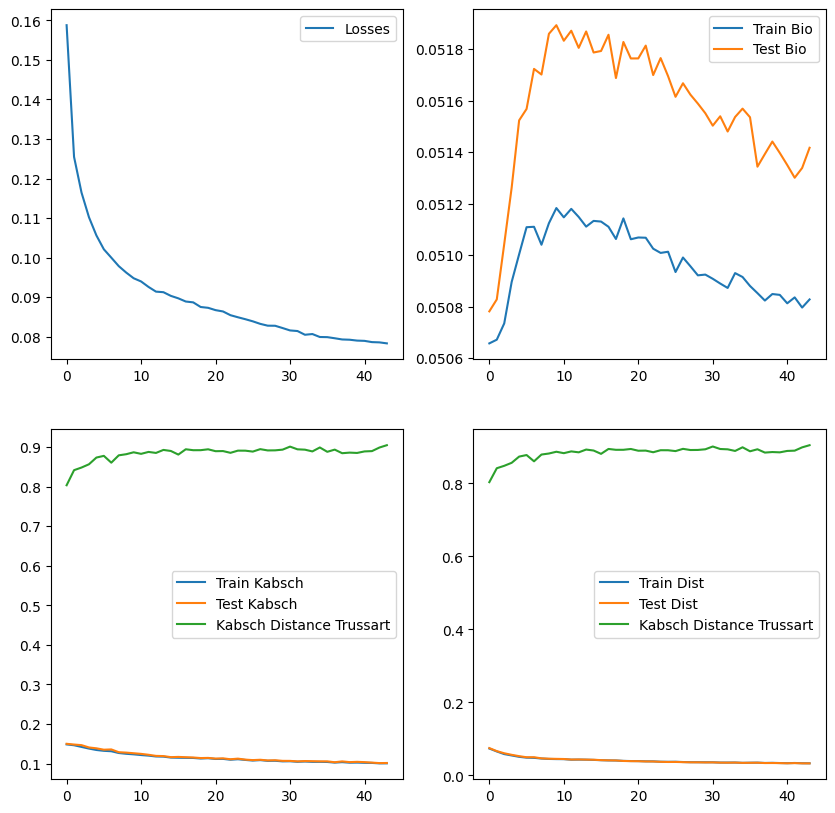

In [18]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, fission_yeast_pearson_loss_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(0.0001)
transformer_encoder.encoder_layers.self_attn.in_proj_weight
tensor(0.0001)
transformer_encoder.encoder_layers.self_attn.out_proj.weight
tensor(8.4124e-05)
transformer_encoder.encoder_layers.linear1.weight
tensor(7.1062e-05)
transformer_encoder.encoder_layers.linear2.weight
tensor(0.0003)
transformer_encoder.encoder_layers.norm1.weight
tensor(0.0004)
transformer_encoder.encoder_layers.norm2.weight
tensor(0.0001)
transformer_encoder.encoder_layers2.self_attn.in_proj_weight
tensor(9.0053e-05)
transformer_encoder.encoder_layers2.self_attn.out_proj.weight
tensor(7.3855e-05)
transformer_encoder.encoder_layers2.linear1.weight
tensor(3.8770e-05)
transformer_encoder.encoder_layers2.linear2.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.norm1.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.norm2.weight
tensor(2.1104e-05)
transformer_encoder.encoder.weight
tensor(0.0023)
transformer_encoder.decoder.weight
tensor(2.0191e-05)
linear_bin_layer.weight
tensor(1.6903

/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



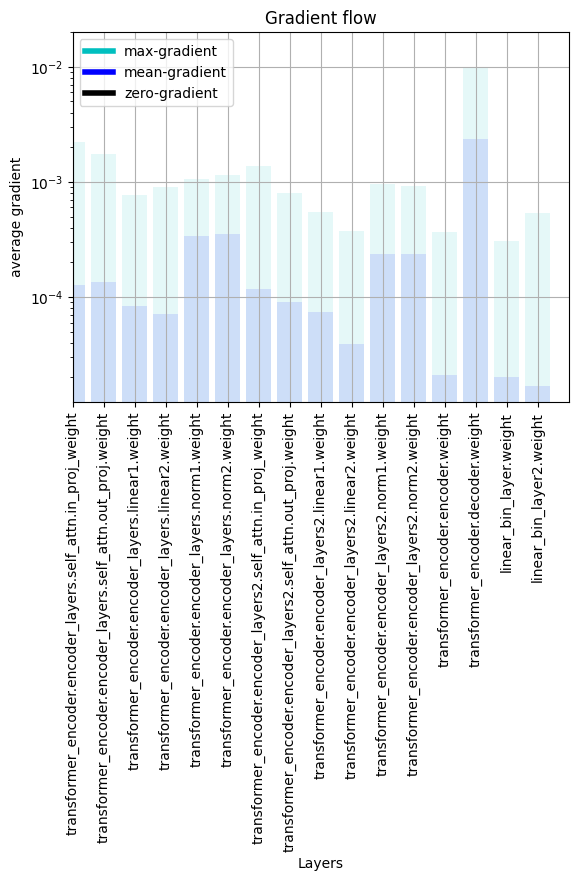

In [19]:
plot_grad_flow(model.named_parameters())

In [20]:
GRAPH_TESTED = 0

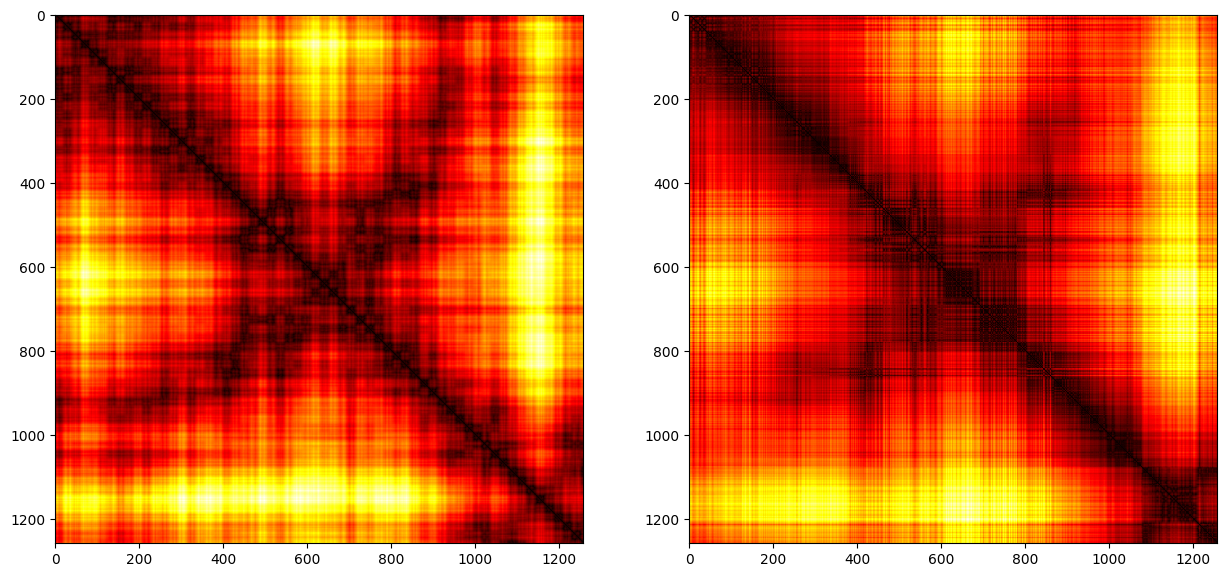

In [21]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [22]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.052468874636098756


<Figure size 50000x50000 with 0 Axes>

In [23]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'magma'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.052468874636098756


<Figure size 50000x50000 with 0 Axes>

In [24]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.8208], dtype=torch.float64)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 202 is different from 1258)

In [26]:
make_gif("", "gifs/fission_yeast_trans.gif")

In [27]:


torch_fission_yeast_hic = torch.FloatTensor(fission_yeast_hic)
torch_fission_yeast_hic = torch.reshape(torch_fission_yeast_hic, (1, NB_BINS, NB_BINS))
torch_fission_yeast_hic = torch.repeat_interleave(torch_fission_yeast_hic, BATCH_SIZE, 0)

fission_yeast_pred_structure, fission_yeast_pred_distance, fission_yeast_pred_logits = model(torch_fission_yeast_hic)
fission_yeast_pred_structure = fission_yeast_pred_structure.detach().numpy()[0]

# Plot structures
x_pred = fission_yeast_pred_structure[:, 0]  
y_pred = fission_yeast_pred_structure[:, 1]
z_pred = fission_yeast_pred_structure[:, 2]

colorscale = np.full(len(fission_yeast_pred_structure[:,0]), 'some non specified color')
colorscale[:558] = 'red'
colorscale[558:1012] = 'green'
colorscale[1012:] = 'blue'
color = 'Viridis'
plot_pred_conf(fission_yeast_pred_structure, colorscale, color)


In [28]:
confidence_metrics, pLLDTs = get_confidence_metrics(fission_yeast_pred_logits.detach().numpy()[0])
print(confidence_metrics)

78.00968552390846


In [29]:
color = 'magma'
plot_pred_conf(fission_yeast_pred_structure, pLLDTs, color)

In [30]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.041
tensor(0.8326, grad_fn=<MulBackward0>)
tensor(0.8323, grad_fn=<MulBackward0>)
tensor(0.8321, grad_fn=<MulBackward0>)
tensor(0.8318, grad_fn=<MulBackward0>)
tensor(0.8315, grad_fn=<MulBackward0>)
tensor(0.8313, grad_fn=<MulBackward0>)
tensor(0.8310, grad_fn=<MulBackward0>)
tensor(0.8308, grad_fn=<MulBackward0>)
tensor(0.8306, grad_fn=<MulBackward0>)
tensor(0.8303, grad_fn=<MulBackward0>)
tensor(0.8301, grad_fn=<MulBackward0>)
tensor(0.8299, grad_fn=<MulBackward0>)
tensor(0.8297, grad_fn=<MulBackward0>)
tensor(0.8294, grad_fn=<MulBackward0>)
tensor(0.8292, grad_fn=<MulBackward0>)
tensor(0.8290, grad_fn=<MulBackward0>)
tensor(0.8288, grad_fn=<MulBackward0>)
tensor(0.8286, grad_fn=<MulBackward0>)
tensor(0.8284, grad_fn=<MulBackward0>)
tensor(0.8282, grad_fn=<MulBackward0>)
tensor(0.8281, grad_fn=<MulBackward0>)
tensor(0.8279, grad_fn=<MulBackward0>)
tensor(0.8277, grad_fn=<MulBackward0>)
tensor(0.8276, grad_fn=<MulBackward0>)
tensor(0.8274, grad_fn=<MulBackw

In [31]:
confidence_metric_scaled, plddt_scaled = scale_logits(fission_yeast_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

77.8078122178297
[73.42521958 73.79314622 73.28779274 ... 73.73165278 73.81006848
 73.96246918]


In [32]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [33]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, fission_yeast_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

3.1648935001554728
3.130339842374576
79.28824316252391
[72.90462267 73.68231915 72.55721133 ... 73.6078219  73.6881448
 73.95343321]


In [34]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [35]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, fission_yeast_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

3.1648935001554728
3.12298730285297
79.11812674915492
[73.85516254 74.31997798 73.57165118 ... 74.50285008 74.59284219
 74.77228473]


In [36]:
color = 'magma'
plot_pred_conf(fission_yeast_pred_structure, plddt_scaled, color)

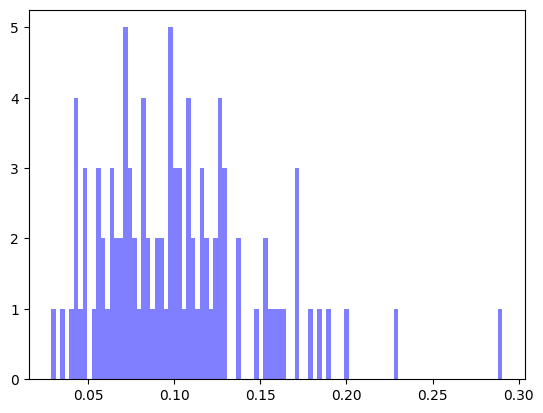

mean: 0.10158291167581365
median: 0.09750837391090231
variance: 0.002014518730167506


In [37]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [41]:
RESULTS_ROOT = '../../saved_results/synthetic_random_fission_yeast/trans/'
LAMBDA_CONFIGURATION = str(LAMBDA_KABSCH)

In [42]:
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_losses_10k_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_train_kabsch_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_test_kabsch_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_train_distance_losses_all_epochs_10k_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_test_distance_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_fission_yeast_test_structure_10k_' +
               LAMBDA_CONFIGURATION + '.txt', fission_yeast_pred_structure)

In [43]:
torch.save(model, 
    '../../saved_models/synthetic_random_fission_yeast/trans/synthetic_random_fission_yeast_linear_model_10k_' 
           + LAMBDA_CONFIGURATION + '.pt')